In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


https://github.com/ajaysh2193/Predicting-Pneumonia-from-X-ray-images-using-CNN-and-Keras

In [2]:
import os
from glob import glob
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.gridspec as gridspec
import seaborn as sns
import zlib
import itertools
import sklearn
import itertools
import scipy
import skimage
from skimage.transform import resize
import csv
from tqdm import tqdm
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import models, layers, optimizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import class_weight
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta, RMSprop
from keras.models import Sequential, model_from_json
from keras.layers import Activation,Dense, Dropout, Flatten, Conv2D, MaxPool2D,MaxPooling2D,AveragePooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras import backend as K
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from keras.applications.vgg19 import VGG19
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications import Xception


%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [3]:
train_dir = "/content/gdrive/My Drive/app/xray/chest_xray/train/"
test_dir = "/content/gdrive/My Drive/app/xray/chest_xray/val/"

def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = skimage.transform.resize(img_file, (200,200,3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X_train, y_train = get_data(train_dir)
X_test, y_test= get_data(test_dir)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

100%|██████████| 9/9 [00:04<00:00,  2.02it/s]


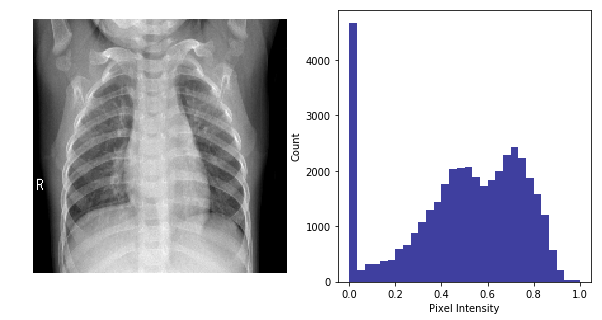

In [4]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X_train[1])

20 images from Normal Category


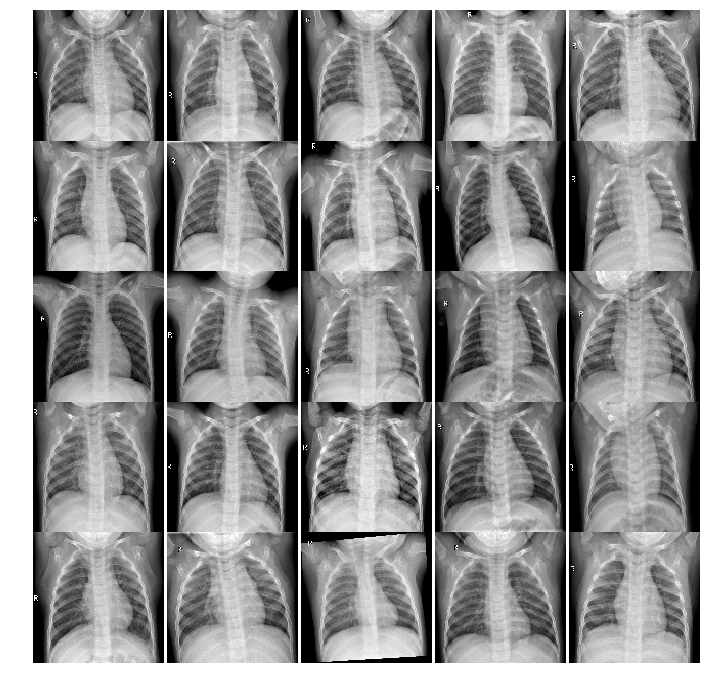

In [7]:

print("20 images from Normal Category")
multipleImages = glob('/content/gdrive/My Drive/app/xray/chest_xray/train/NORMAL/**')
i_ = 0
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

20 images Pneumonia Category


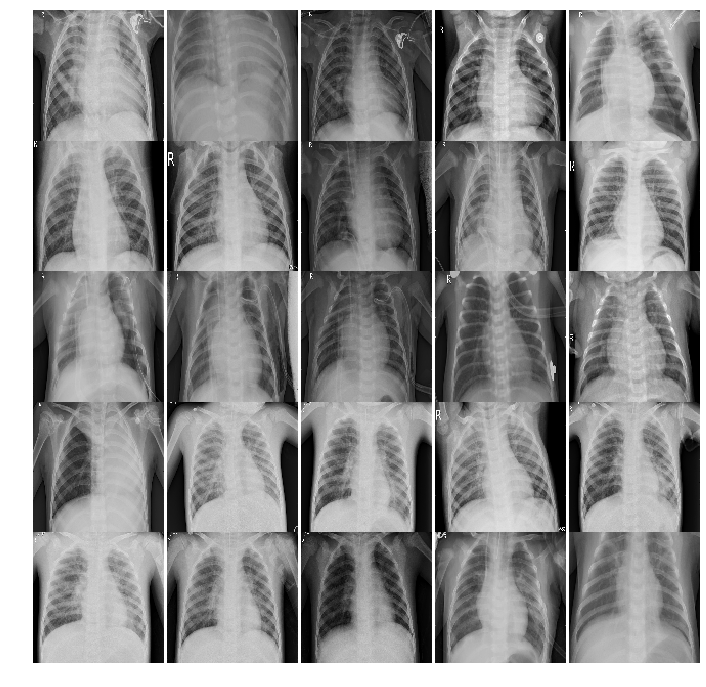

In [8]:
print("20 images Pneumonia Category")
multipleImages = glob('/content/gdrive/My Drive/app/xray/chest_xray/train/PNEUMONIA/**')
i_ = 0
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


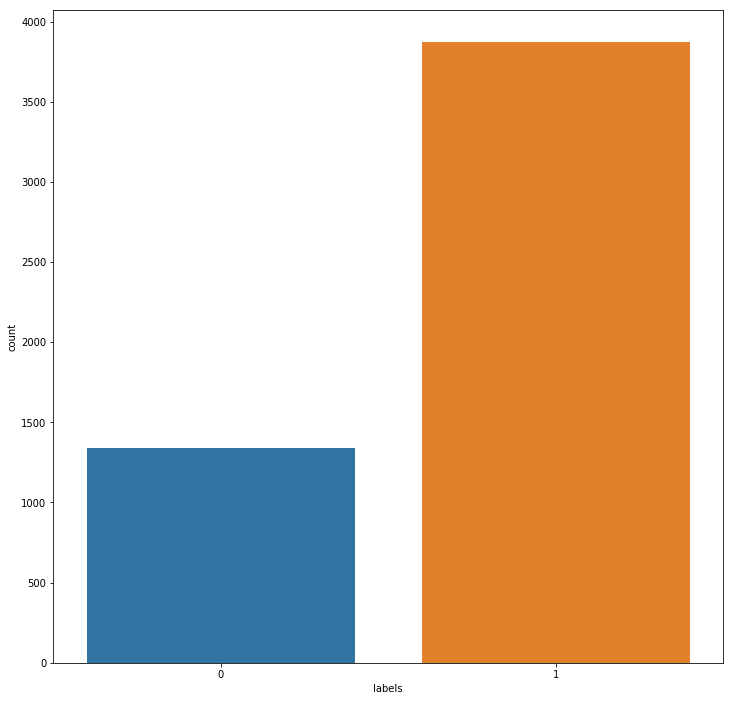

In [9]:
map_characters = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
dict_characters=map_characters
import seaborn as sns
df = pd.DataFrame()
df["labels"]=y_train
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [0]:
# Helper Functions  Learning Curves and Confusion Matrix

from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.ylabel('Accuracy')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/gdrive/My Drive/app/xray/accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('/content/gdrive/My Drive/app/xray/loss_curve.png')

In [12]:
map_characters1 = {0: 'No Pneumonia', 1: 'Yes Pneumonia'}
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
#weight_path1 = './imagenet_models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
#weight_path2 = './imagenet_models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
#weight_path3 = './imagenet_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
#weight_path4 = './imagenet_models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
#weight_path5 = './imagenet_models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

weight_path1 = 'imagenet'
weight_path2 = 'imagenet'
weight_path3 = 'imagenet'
weight_path4 = 'imagenet'
weight_path5 = 'imagenet'


pretrained_model_1 = VGG16(weights = weight_path1, include_top=False, input_shape=(200, 200, 3))
pretrained_model_2 = InceptionV3(weights = weight_path2, include_top=False, input_shape=(200, 200, 3))
pretrained_model_3 = ResNet50(weights = weight_path3, include_top=False, input_shape=(200, 200, 3))
pretrained_model_4 = InceptionResNetV2(weights = weight_path4, include_top=False, input_shape=(200, 200, 3))
pretrained_model_5 = Xception(weights = weight_path5, include_top=False, input_shape=(200, 200, 3))
optimizer1 = keras.optimizers.Adam(lr=0.0001)
def pretrainedNetwork(xtrain,ytrain,xtest,ytest,pretrainedmodel,pretrainedweights,classweight,numclasses,numepochs,optimizer,labels):
    base_model = pretrained_model_1 # Topless
    # Add top layer
    x = base_model.output
    x = Flatten()(x)
    predictions = Dense(numclasses, activation='relu')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    # Train top layer
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, verbose=1)]
    model.summary()
    # Fit model
    history = model.fit(xtrain,ytrain, epochs=numepochs, class_weight=classweight, validation_data=(xtest,ytest), verbose=1,callbacks = [MetricsCheckpoint('logs')])
    # Evaluate model
    score = model.evaluate(xtest,ytest, verbose=0)
    print('\nKeras CNN - accuracy:', score[1], '\n')
    y_pred = model.predict(xtest)
    print('\n', sklearn.metrics.classification_report(np.where(ytest > 0)[1], np.argmax(y_pred, axis=1), target_names=list(labels.values())), sep='') 
    Y_pred_classes = np.argmax(y_pred,axis = 1) 
    Y_true = np.argmax(ytest,axis = 1) 
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_learning_curve(history)
    plt.show()
    plot_confusion_matrix(confusion_mtx, classes = list(labels.values()))
    plt.show()
    return model

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 3s 0us/step


{0: 'No Pneumonia', 1: 'Yes Pneumonia'}


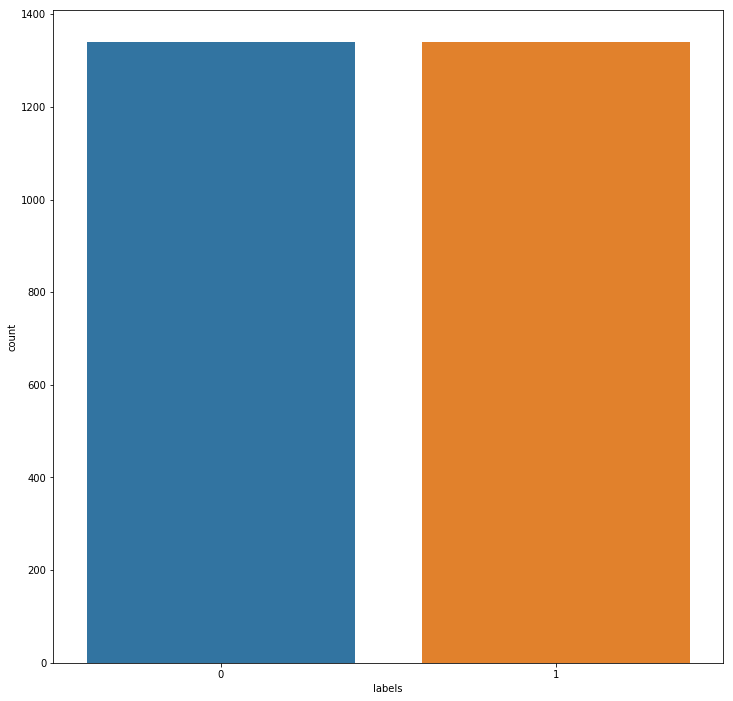

In [13]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
Y_train = y_train
Y_test = y_test
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
# Make Data 2D again
for i in range(len(X_trainRos)):
    height, width, channels = 200,200,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
for i in range(len(X_testRos)):
    height, width, channels = 200,200,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
# Plot Label Distribution
dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [14]:
class_weight1 = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
print("Old Class Weights: ",class_weight1)
class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
print("New Class Weights: ",class_weight2)

Old Class Weights:  [1.9448173  0.67303226]
New Class Weights:  [1. 1.]


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

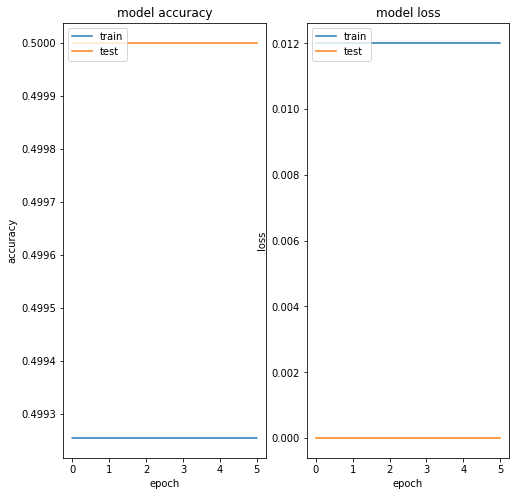

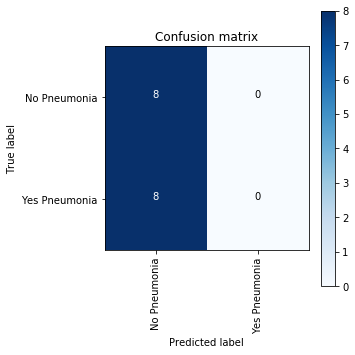

In [21]:
model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_1,weight_path1,class_weight2,2,6,optimizer1,map_characters1)

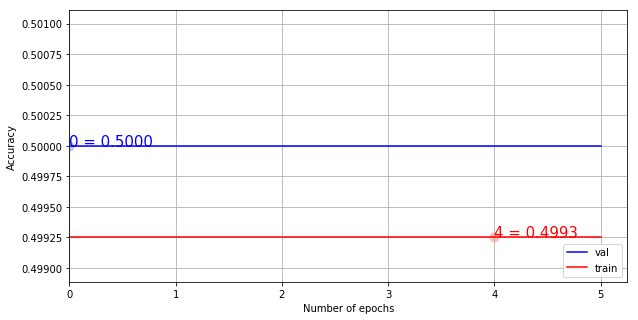

In [22]:
plotKerasLearningCurve()
plt.show()

Viem Phoi
[[0.        2.3644521]]
0.0
2.3644521


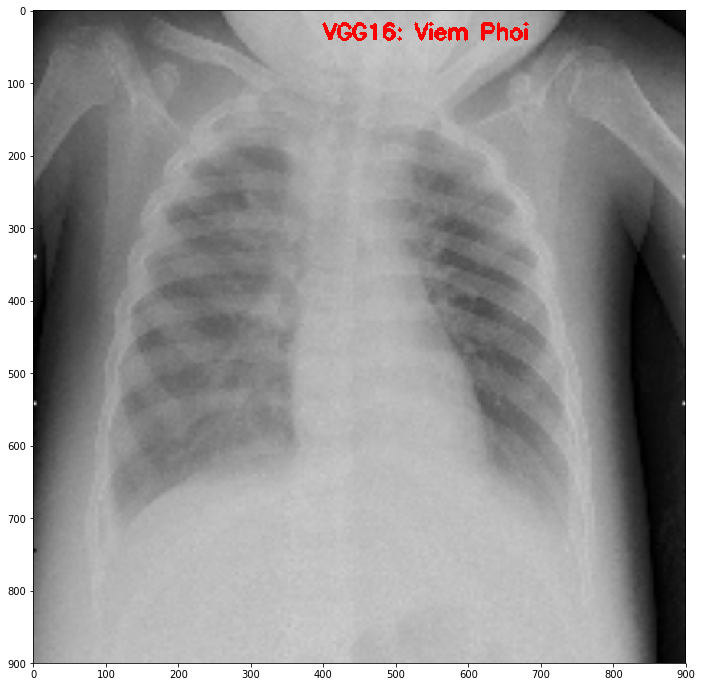

In [26]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

#img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(200, 200))
img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/test/PNEUMONIA/person1682_virus_2899.jpeg", target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

numpy_image = np.uint8(img_to_array(img)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))
label = "Binh Thuong" if classes[0][0] == 1 else "Viem Phoi"
cv2.putText(numpy_image, "VGG16: {}".format(label) , (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.imshow(numpy_image)
#plt.savefig('/content/gdrive/My Drive/app/xray/vgg16/test1.png')
print(label)
print(classes)
print(classes[0][0])
print(classes[0][1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

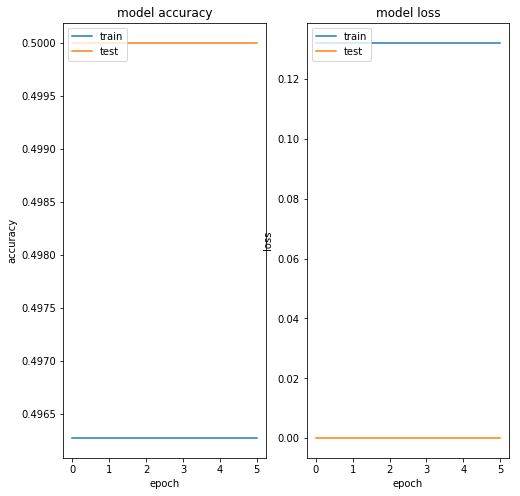

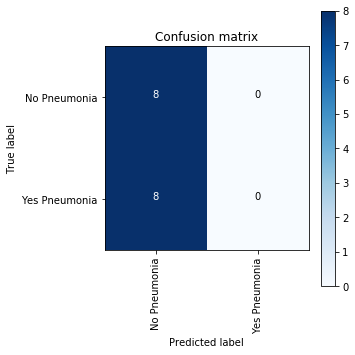

In [27]:
model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_2,weight_path2,class_weight2,2,6,optimizer1,map_characters1)

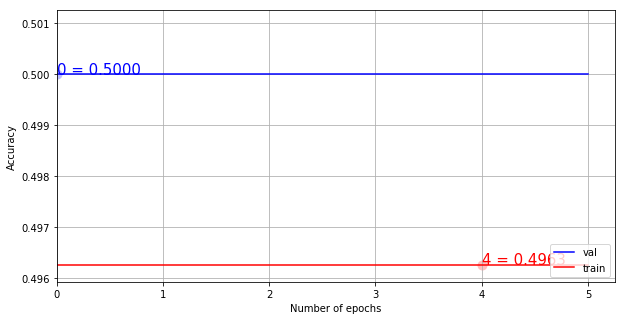

In [28]:
plotKerasLearningCurve()
plt.show()

Viem Phoi
[[0.         0.05754536]]
0.0
0.057545364


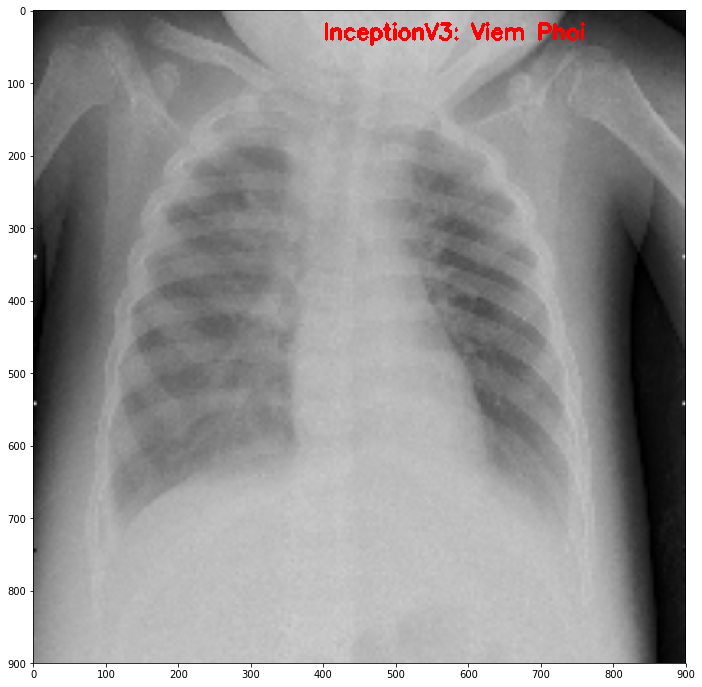

In [29]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

#img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(200, 200))
img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/test/PNEUMONIA/person1682_virus_2899.jpeg", target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

numpy_image = np.uint8(img_to_array(img)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))
label = "Binh Thuong" if classes[0][0] == 1 else "Viem Phoi"
cv2.putText(numpy_image, "InceptionV3: {}".format(label) , (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.imshow(numpy_image)
#plt.savefig('/content/gdrive/My Drive/app/xray/vgg16/test1.png')
print(label)
print(classes)
print(classes[0][0])
print(classes[0][1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

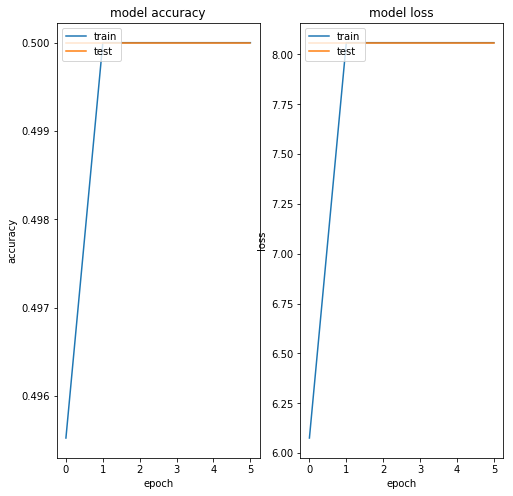

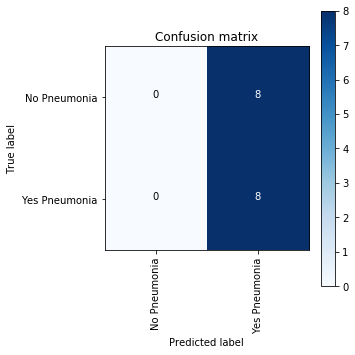

In [30]:
model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_3,weight_path3,class_weight2,2,6,optimizer1,map_characters1)

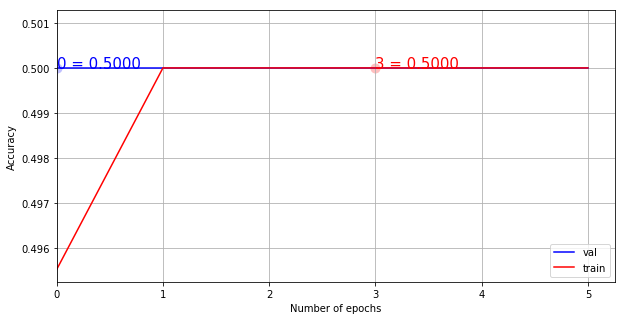

In [31]:
plotKerasLearningCurve()
plt.show()

Viem Phoi
[[ 0.     43.1152]]
0.0
43.1152


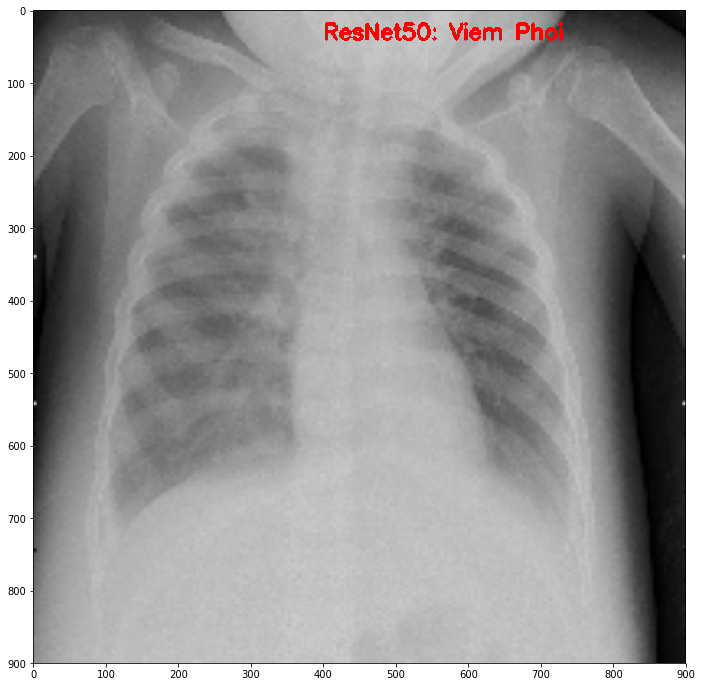

In [32]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

#img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(200, 200))
img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/test/PNEUMONIA/person1682_virus_2899.jpeg", target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

numpy_image = np.uint8(img_to_array(img)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))
label = "Binh Thuong" if classes[0][0] == 1 else "Viem Phoi"
cv2.putText(numpy_image, "ResNet50: {}".format(label) , (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.imshow(numpy_image)
#plt.savefig('/content/gdrive/My Drive/app/xray/vgg16/test1.png')
print(label)
print(classes)
print(classes[0][0])
print(classes[0][1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

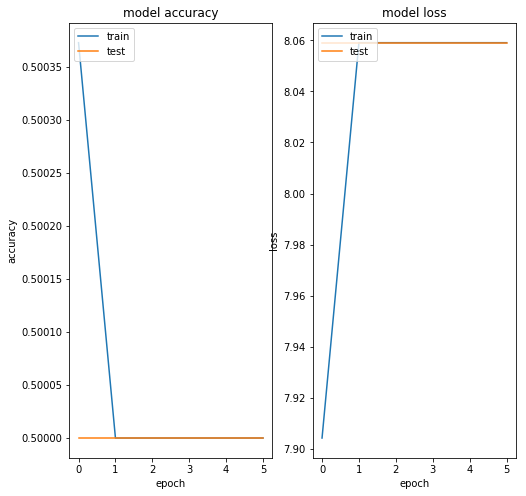

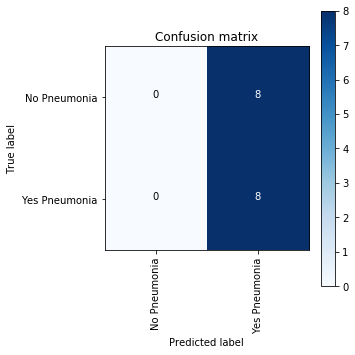

In [33]:
model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_4,weight_path4,class_weight2,2,6,optimizer1,map_characters1)

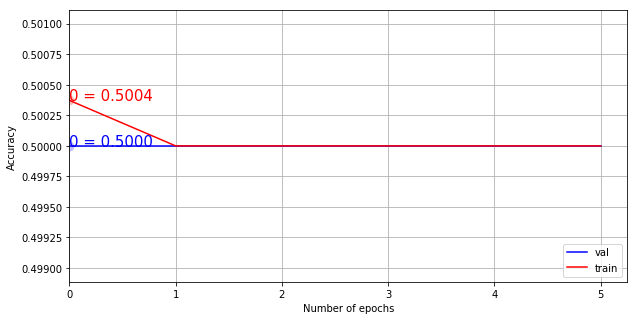

In [34]:
plotKerasLearningCurve()
plt.show()

Viem Phoi
[[ 0.       32.937206]]
0.0
32.937206


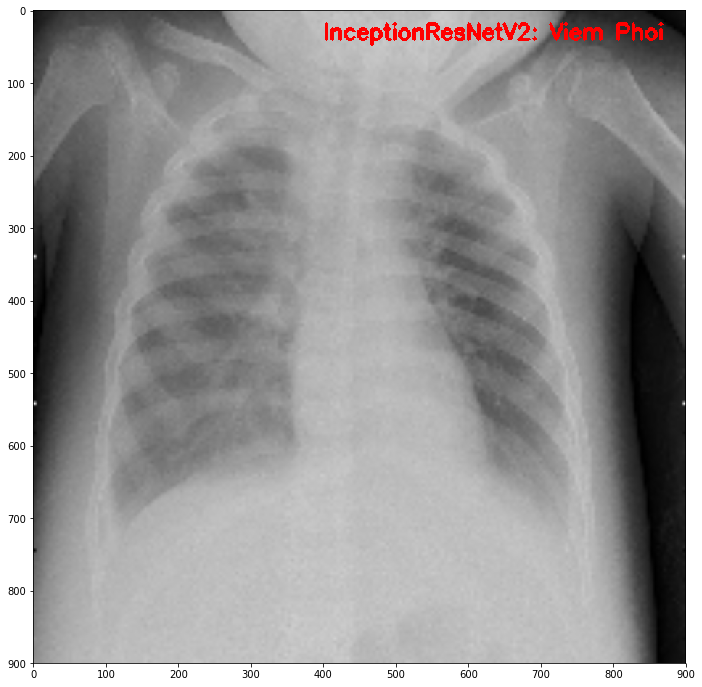

In [35]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

#img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(200, 200))
img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/test/PNEUMONIA/person1682_virus_2899.jpeg", target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

numpy_image = np.uint8(img_to_array(img)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))
label = "Binh Thuong" if classes[0][0] == 1 else "Viem Phoi"
cv2.putText(numpy_image, "InceptionResNetV2: {}".format(label) , (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.imshow(numpy_image)
#plt.savefig('/content/gdrive/My Drive/app/xray/vgg16/test1.png')
print(label)
print(classes)
print(classes[0][0])
print(classes[0][1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

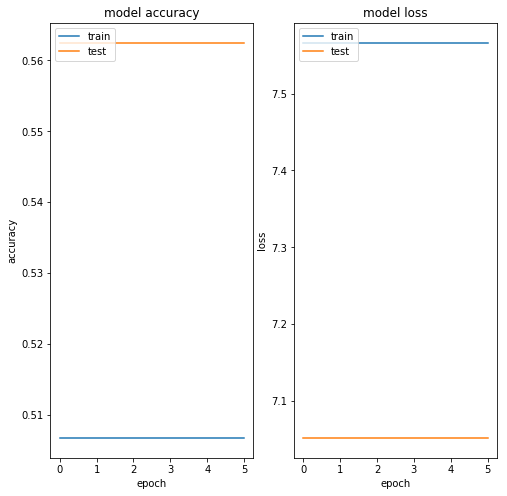

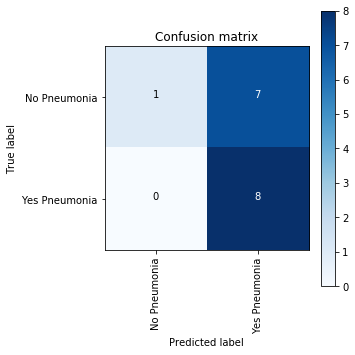

In [37]:
model=pretrainedNetwork(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,pretrained_model_5,weight_path5,class_weight2,2,6,optimizer1,map_characters1)

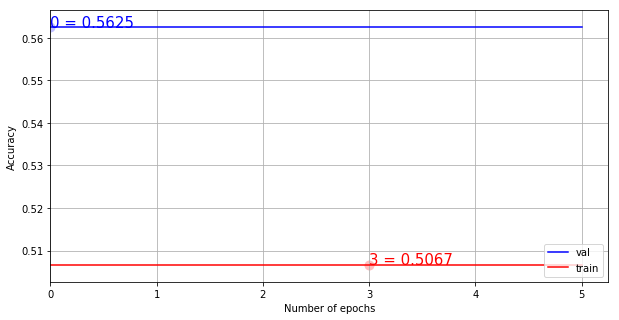

In [38]:
plotKerasLearningCurve()
plt.show()

Viem Phoi
[[0.       1.872464]]
0.0
1.872464


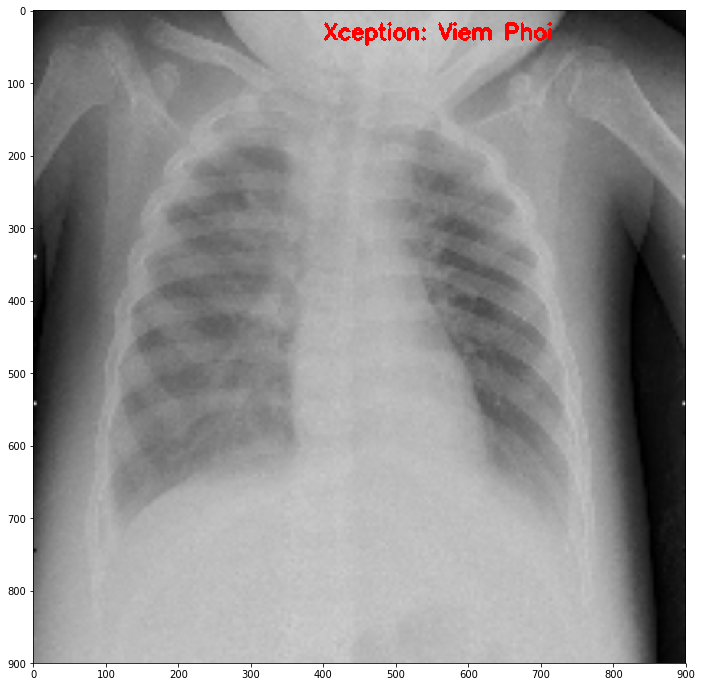

In [39]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import img_to_array

#img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg", target_size=(200, 200))
img = image.load_img("/content/gdrive/My Drive/app/xray/chest_xray/test/PNEUMONIA/person1682_virus_2899.jpeg", target_size=(200, 200))

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)

numpy_image = np.uint8(img_to_array(img)).copy()
numpy_image = cv2.resize(numpy_image,(900,900))
label = "Binh Thuong" if classes[0][0] == 1 else "Viem Phoi"
cv2.putText(numpy_image, "Xception: {}".format(label) , (400, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 3)

plt.imshow(numpy_image)
#plt.savefig('/content/gdrive/My Drive/app/xray/vgg16/test1.png')
print(label)
print(classes)
print(classes[0][0])
print(classes[0][1])